In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [5]:
data = pd.read_csv("ski.csv")
weights = pd.read_csv("morgenvekt.csv")

In [6]:
data.head()

,Date,Activity,Distance(m),Time,Location,Elsa
0,2020-02-24,ski-skate,4380,0,Bymarka,1
1,2020-02-29,ski-classic,7290,0,Bymarka,1
2,2020-03-01,ski-classic,12250,0,Bymarka,1
3,2020-03-02,ski-classic,7290,0,Bymarka,1
4,2020-03-03,ski-classic,7290,0,Bymarka,1


In [24]:
distance = data["Distance(m)"]
print("Total distance: ", np.sum(distance), "meter")

Total distance:  74110 meter


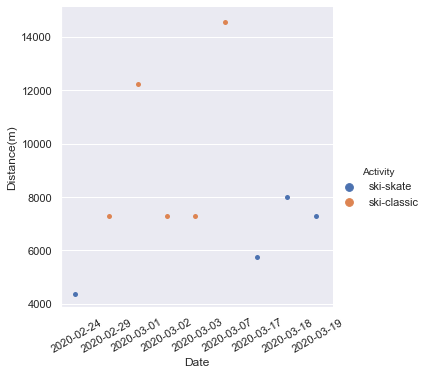

In [20]:
p = sns.catplot(x="Date", y="Distance(m)", hue="Activity", data=data)
p.set_xticklabels(rotation=30)

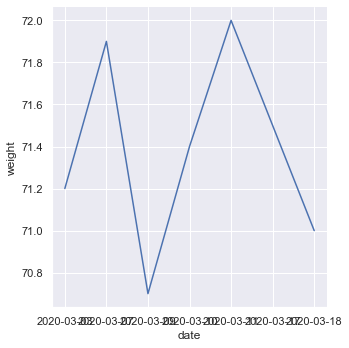

In [8]:
sns.relplot(x="date", y="weight", kind="line", data=weights)